This python notebook illustrate for a small dust map on the sphere (Nside=128) the different steps to follow:

* To create all patches on the sphere

* To create a training set

* To learn a sparsifying dictionary from the data

* To use it for denoising 

# 0) Environment setup 

In [142]:
import math
import healpy as hp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits as fits
import copy
import os
import sys
import shlex,subprocess,glob,os
import scipy
from scipy import stats as stats
DtoR=math.pi/180. 

## Get current package python files

In [75]:
import sys
sys.path.insert(0, '../python')
import split_faces as sf
import extract_Dust_Regions

## Define function to create redundant DCT dictionary

In [76]:
def initDCT(nSqrtAtoms,PatchWidth,fname=None,plot=False):
    #INIT A DICTIONARY WITH nSqrtAtoms**2 ATOMS OF SIZE PatchWidth*PatchWidth WITH DCT
    katoms= nSqrtAtoms* nSqrtAtoms
    natoms=[katoms]
    InitDictionary=np.zeros((PatchWidth, nSqrtAtoms))
    for k in range(nSqrtAtoms):
        cos1d=np.cos(np.arange(PatchWidth)*k*math.pi/nSqrtAtoms)
        if k>0:
            cos1d = cos1d-np.mean(cos1d)
        InitDictionary[:,k]= cos1d/np.linalg.norm(cos1d)
    InitDictionary =np.kron(InitDictionary, InitDictionary)#(PatchWidth* PatchWidth, nSqrtAtoms* nSqrtAtoms)
    if(fname is not None):
        phdu=fits.PrimaryHDU(data=copy.deepcopy(InitDictionary))
        phdu.writeto(fname,clobber=True)
    if(plot):
        plt.figure()
        for k in range(nSqrtAtoms* nSqrtAtoms):
            plt.subplot(nSqrtAtoms, nSqrtAtoms,k+1),plt.imshow(np.reshape(InitDictionary[:,k],(PatchWidth, PatchWidth)))
    return InitDictionary

## Set up parameters for plotting, DL

In [77]:
%matplotlib inline
nested=False

matplotlib.rcParams['figure.figsize']=[12,8]
plt.rcParams['image.cmap']='jet'#'viridis' before




## Useful paths

In [85]:
root_path=os.getcwd()
data_path=root_path+"/../../data"
approx_path=data_path+"/approx"
dico_path=data_path+"/dico"
training_path=data_path+"/training"
input_path=data_path+"/input"
binDir=root_path+"/../bin"

## Inputs

NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


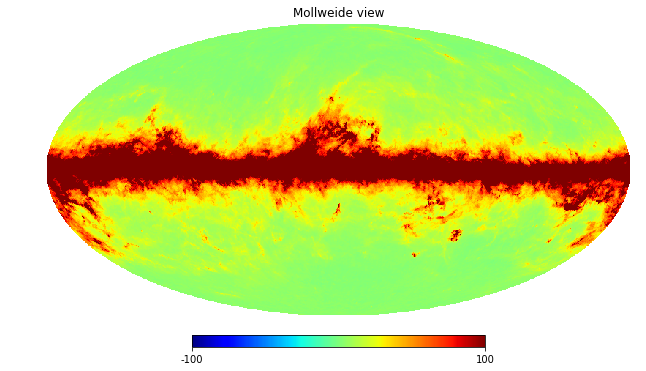

In [121]:
nsideMap=128
npix=hp.nside2npix(nsideMap)
inputdust=hp.read_map(data_path+"/ffp8_thermaldust_nobpm_100_full_map_ns{0}.fits".format(nsideMap)) #Temperature in muK
PatchWidth=5
hp.mollview(inputdust,min=-100,max=100)

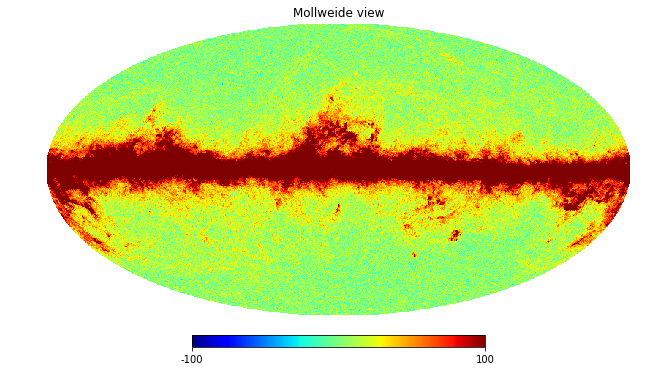

In [194]:
seedNoise=1041978
np.random.seed(seed=seedNoise)
sigmaNoise=10.0
noisyMap=inputdust+np.random.normal(size=(npix))*sigmaNoise
noisy_name=data_path+"/ffp8_thermaldust_nobpm_100_full_map_ns{0}_noisy{1}.fits".format(nsideMap,int(sigmaNoise))
hp.write_map(noisy_name,noisyMap,overwrite=True) #Temperature in muK
hp.mollview(noisyMap,min=-100,max=100)

# 1) Patch Extraction

In [133]:
totalNPatches=0
for face in range(12):
    Patches,ppf=sf.getFace2DPatches(inputdust,PatchWidth,face)
    Patchesr=np.reshape(Patches,(np.shape(Patches)[0],PatchWidth*PatchWidth))
    name_allpatch=input_path+"/AllPatches_tdust_face{2}_width{0}_nside{1}_new.fits".format(PatchWidth,nsideMap,face)
    phdu=fits.PrimaryHDU(data=copy.deepcopy(Patchesr))
    phdu.writeto(name_allpatch,clobber=True)
    totalNPatches=totalNPatches+ppf


In [145]:
totalNPatchesNoisy=0
for face in range(12):
    Patches,ppf=sf.getFace2DPatches(noisyMap,PatchWidth,face)
    Patchesr=np.reshape(Patches,(np.shape(Patches)[0],PatchWidth*PatchWidth))
    name_allpatch_noisy=input_path+"/AllPatchesNoisy_tdust_face{2}_width{0}_nside{1}_s{2}_new.fits".format(PatchWidth,nsideMap,face,sigmaNoise)
    phdu=fits.PrimaryHDU(data=copy.deepcopy(Patchesr))
    phdu.writeto(name_allpatch_noisy,clobber=True)
    totalNPatchesNoisy=totalNPatchesNoisy+ppf



## Check reconstruction

Process face 0
Process face 1
Process face 2
Process face 3
Process face 4
Process face 5
Process face 6
Process face 7
Process face 8
Process face 9
Process face 10
Process face 11
('MAXDIFF=', 0.0)


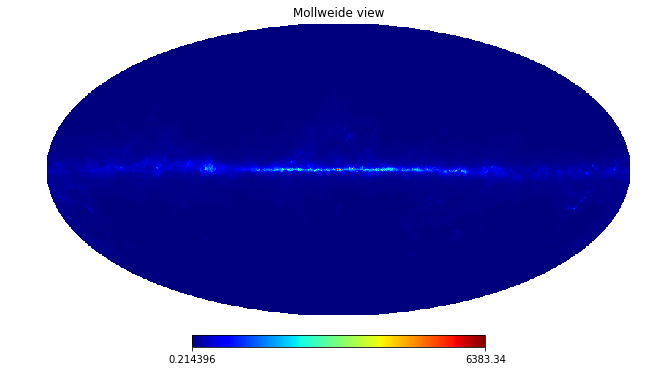

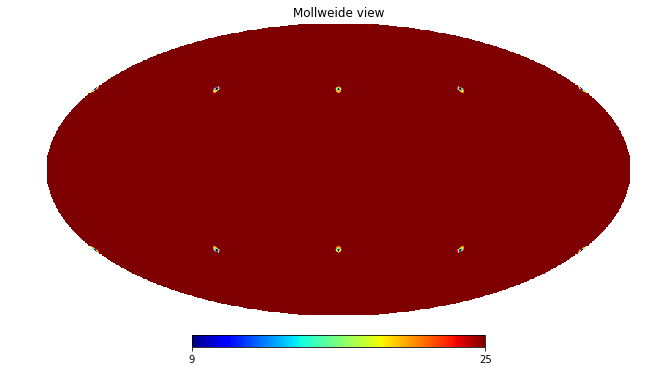

In [134]:
Image=np.zeros((npix))
Cover=np.zeros((npix),dtype='int64')
for face in range(12):
    print("Process face {0}".format(face))
    name_allpatch=input_path+"/AllPatches_tdust_face{2}_width{0}_nside{1}_new.fits".format(PatchWidth,nsideMap,face)
    Patchesctr=fits.getdata(name_allpatch)
    sf.putFace2DPatches(Image,Cover,Patchesctr,face)
Image=Image/Cover
hp.mollview(Image)
print("MAXDIFF=",np.max(np.abs(Image-inputdust)))
hp.mollview(Cover)

# 2) Construct training set

In [146]:
ntrain=10000
TrainingPatchesr=np.zeros((ntrain,PatchWidth*PatchWidth))
offPatches=0
NperFace=ntrain//12
newSet =''#'_red'
seedTrain= 190247
np.random.seed(seed=seedTrain)
for face in range(12):
    name_allpatch=input_path+"/AllPatches_tdust_face{2}_width{0}_nside{1}_new.fits".format(PatchWidth,nsideMap,face)
    PatchFaces=fits.getdata(name_allpatch)
    trainIndices=np.random.randint(0,high=PatchFaces.shape[0],size=NperFace).astype('int64')
    TrainingPatchesr[offPatches:offPatches+NperFace]=PatchFaces[trainIndices]
    offPatches=offPatches+NperFace
NResFace=ntrain-offPatches
trainIndices=np.random.randint(0,high=PatchFaces.shape[0],size=NResFace).astype('int64')
TrainingPatchesr[offPatches:ntrain]=PatchFaces[trainIndices]
name_trainingpatch=input_path+"/Patches_tdust_width{0}_nside{1}_training{2}_seed{3}.fits".format(PatchWidth,\
                                                                                    nsideMap,ntrain,seedTrain)
phdu=fits.PrimaryHDU(data=copy.deepcopy(TrainingPatchesr))
phdu.writeto(name_trainingpatch,clobber=True)


## 3) Learning

### DCT Dictionary for initialization

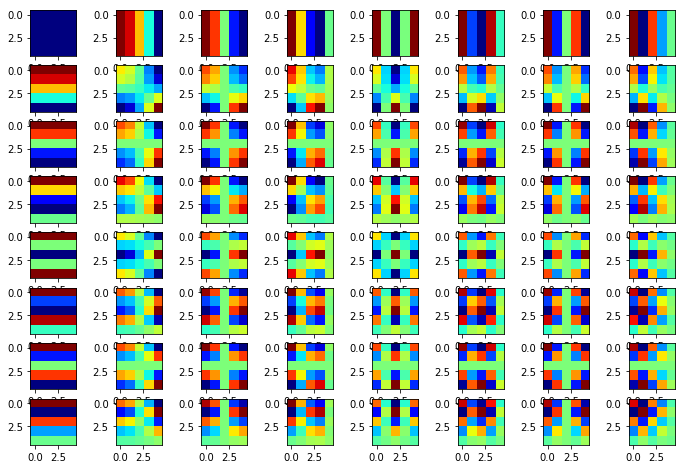

In [147]:
nSqrtAtoms=8
natoms=nSqrtAtoms*nSqrtAtoms
name_initDico= input_path +"/DicoInit_DCT_width{0}_natoms{1}.fits".format(PatchWidth, natoms)
InitDico=initDCT(nSqrtAtoms,PatchWidth,fname=name_initDico,plot=True)

### DL code parameters

In [157]:
dl_file=binDir+"/dl_learning"
command_line=shlex.split(exec_file)
out = subprocess.check_output(command_line)
print(out)

Usage: /Users/fsureau/projects/DEDALE/ARES/DL/notebook/../bin/sparse_decomp options nameDicoIn.fits nameVectIn.fits nameCodeOut.fits 

   where options =  
      [-e ErrorTarget, TargetSparsity ignored]
      [-s TargetSparsity]
      [-m name of fits file containing input metric for selection of atoms]
      [-w name of fits file containing input metric for selection and approximation]
      [-p Name of optional mean input to subtract
          from each input]
      [-a Name for training set approx to save]
      [-C center training patches (mean of each patch=0)]
      [-N do not save the final code]
      [-T Timing on]
      [-V verbose]



### Launch learning

In [197]:
NbItLearning=30
sparsity=10
error=sigmaNoise
rootname="PatchesDust_Sphere_width{0}_nside{1}_training{2}_seed190247_{3}sp{4}_it{5}".format(\
                                                    PatchWidth,nsideMap,ntrain,sparsity,natoms,NbItLearning)
approx_file=training_path+"/{0}_approx.fits".format(rootname)
out_dico=dico_path+"/dicolearn_{0}.fits".format(rootname)
opt_exec=" -n {0} -g 1 -R -i {1} -T -s {2} -e {3} -a {4} -C -d {5} {6} {7}".format(natoms,NbItLearning,sparsity,error,\
                                    approx_file,name_initDico,name_trainingpatch,out_dico)
command_line=shlex.split(dl_file+opt_exec)
print(dl_file+opt_exec)
subprocess.call(command_line)



/Users/fsureau/projects/DEDALE/ARES/DL/notebook/../bin/dl_learning -n 64 -g 1 -R -i 30 -T -s 10 -e 10.0 -a /Users/fsureau/projects/DEDALE/ARES/DL/notebook/../../data/training/PatchesDust_Sphere_width5_nside128_training10000_seed190247_10sp64_it30_approx.fits -C -d /Users/fsureau/projects/DEDALE/ARES/DL/notebook/../../data/input/DicoInit_DCT_width5_natoms64.fits /Users/fsureau/projects/DEDALE/ARES/DL/notebook/../../data/input/Patches_tdust_width5_nside128_training10000_seed190247.fits /Users/fsureau/projects/DEDALE/ARES/DL/notebook/../../data/dico/dicolearn_PatchesDust_Sphere_width5_nside128_training10000_seed190247_10sp64_it30.fits


0

### Display learnt dictionary

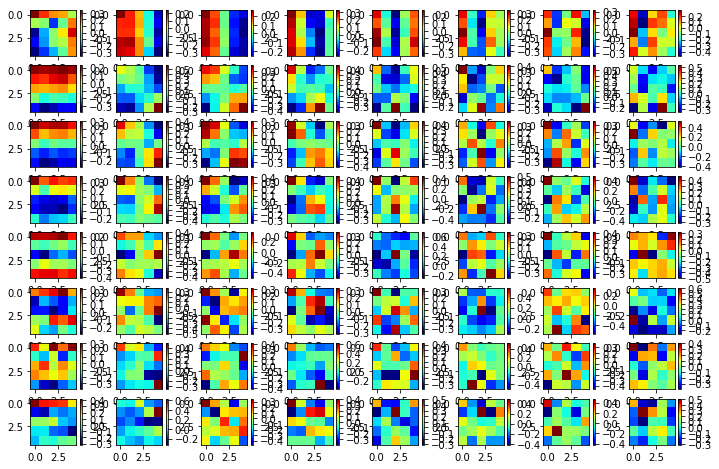

In [198]:
dico_est=fits.getdata(out_dico)
dico_est.shape
plt.figure()
for k in range(64):
     plt.subplot(8, 8,k+1),plt.imshow(np.reshape(dico_est[:,k],(PatchWidth,PatchWidth))),plt.colorbar()

## 4) Sparse Decomposition with this dictionary

In [199]:
decomp_file=binDir+"/sparse_decomp"
errordecomp=math.sqrt(stats.chi2.ppf(0.9545, PatchWidth* PatchWidth))*sigmaNoise
for face in range(12):
    print("Process face {0}".format(face))
    name_allpatch_noisy=input_path+"/AllPatchesNoisy_tdust_face{2}_width{0}_nside{1}_s{2}_new.fits".format(PatchWidth,nsideMap,face,sigmaNoise)
    allP_approx=output_approx_path+"/Approx_all{0}_face{1}.fits".format(rootname,face)
    allP_code=output_approx_path+"/Code_all{0}_face{1}.fits".format(rootname,face)
    opt_exec=" -s {0} -e {1} -C -T -a {2} {3} {4} {5}".format(sparsity,errordecomp,allP_approx,out_dico,name_allpatch_noisy,allP_code)
    print(decomp_file+opt_exec)
    command_line=shlex.split(decomp_file+opt_exec)
    subprocess.call(command_line)




Process face 0
/Users/fsureau/projects/DEDALE/ARES/DL/notebook/../bin/sparse_decomp -s 10 -e 61.7039631404 -C -T -a /Users/fsureau/projects/DEDALE/ARES/DL/notebook/../../data/approx/Approx_allPatchesDust_Sphere_width5_nside128_training10000_seed190247_10sp64_it30_face0.fits /Users/fsureau/projects/DEDALE/ARES/DL/notebook/../../data/dico/dicolearn_PatchesDust_Sphere_width5_nside128_training10000_seed190247_10sp64_it30.fits /Users/fsureau/projects/DEDALE/ARES/DL/notebook/../../data/input/AllPatchesNoisy_tdust_face0_width5_nside128_s0_new.fits /Users/fsureau/projects/DEDALE/ARES/DL/notebook/../../data/approx/Code_allPatchesDust_Sphere_width5_nside128_training10000_seed190247_10sp64_it30_face0.fits
Process face 1
/Users/fsureau/projects/DEDALE/ARES/DL/notebook/../bin/sparse_decomp -s 10 -e 61.7039631404 -C -T -a /Users/fsureau/projects/DEDALE/ARES/DL/notebook/../../data/approx/Approx_allPatchesDust_Sphere_width5_nside128_training10000_seed190247_10sp64_it30_face1.fits /Users/fsureau/projec

## 5) Reconstruct from patches

Process face 0
Process face 1
Process face 2
Process face 3
Process face 4
Process face 5
Process face 6
Process face 7
Process face 8
Process face 9
Process face 10
Process face 11


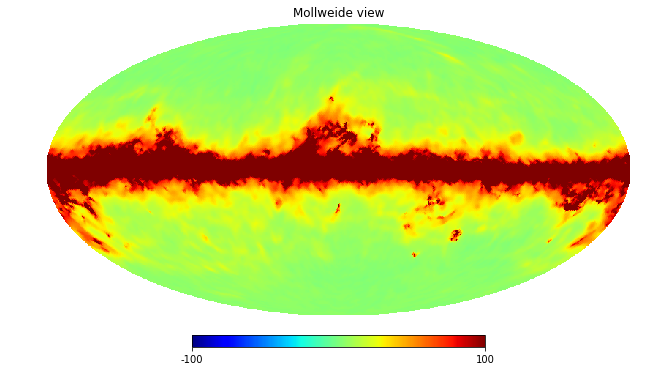

In [200]:
DenImage=np.zeros((npix))
Cover=np.zeros((npix),dtype='int64')
for face in range(12):
    print("Process face {0}".format(face))
    allP_approx=output_approx_path+"/Approx_all{0}_face{1}.fits".format(rootname,face)
    Patchesctr=fits.getdata(allP_approx)
    sf.putFace2DPatches(DenImage,Cover,Patchesctr,face)
DenImage=DenImage/Cover
hp.mollview(DenImage,min=-100,max=100)


In [201]:
print(np.linalg.norm(inputdust-noisyMap)/np.sqrt(npix))
print(np.linalg.norm(DenImage-inputdust)/np.sqrt(npix))

9.970910773557035
4.507464663565821
